# Topographic VAE tutorial

This notebook allows users to train models on both dummy data and the kinematic data used in [Blum et al 2022](https://www.biorxiv.org/content/10.1101/2021.12.10.472161v3) which can be downloaded [here](https://figshare.com/articles/dataset/Behavioural_kinematics_and_S1_neural_activity_datasets/17700944).

### Import packages and set seed

In [1]:
from tvae.models import BernoulliTopoVAE
from tvae.utils import lateral_effect, mexican_hat, load_kinematic_data, plot_PD_map

import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.linear_model import PoissonRegressor
from sklearn.multioutput import MultiOutputRegressor

# Set seed
SEED = 2022
torch.manual_seed(SEED);

### Training & evaluating a model on dummy data

Generate dummy data

In [2]:
# Hyperparameters
INPUT_SIZE = 9
N_SAMPLES = 10000

# Dataset of N dimensional gaussian noise
data = torch.randn(size=(N_SAMPLES, INPUT_SIZE))

# Move to GPU (remove this line if not using GPU for training)
data = data.cuda()

# Wrap data in dataloader object
dataloader = DataLoader(data, batch_size=256, drop_last=True, shuffle=True) 

Initialise model

In [3]:
# Hyperparameters
LATENT_SHAPE = [20,20] # Dimensions of 2D latent space 
LATENT_DIM = LATENT_SHAPE[0] * LATENT_SHAPE[1] # No. of neurons in 2D latent space
SIGMA = 2 # Controls range of lateral effects
N = 5 # Maximum allowed spike range of each neuron for a single input

# Initialise Psi, which defines the desired pairwise interactions between neurons
psi = lateral_effect(LATENT_SHAPE, SIGMA, mexican_hat)
psi = torch.tensor(psi).float()

# Initialise model
model = BernoulliTopoVAE(INPUT_SIZE, LATENT_DIM, psi, n=N, device='cpu')

# Move model compoinents to GPU (remove these lines if not using GPU for training)
model.device = 'cuda:0'
model.psi = model.psi.cuda()
model.cuda()

BernoulliTopoVAE(
  (encoder): Sequential(
    (0): Linear(in_features=9, out_features=500, bias=False)
    (1): Tanh()
    (2): Linear(in_features=500, out_features=400, bias=False)
    (3): Sigmoid()
  )
  (decoder): Linear(in_features=400, out_features=9, bias=False)
)

Train model

In [4]:
# Training hyperparameters
N_EPOCHS = 500
LATERAL_WEIGHT = 1
KL_WEIGHT = 0

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

losses = {'total':[], 'reconstruction':[], 'lateral':[]}

for epoch in range(N_EPOCHS):

    total_losses, recon_losses, lateral_losses = [], [], []

    for i_batch, x in enumerate(dataloader):

        optimizer.zero_grad()

        xhat, z, pi, p, inp = model.forward(x)

        reconstruction_loss = loss_fn(x.cpu(), xhat.cpu())
        lateral_loss = model.lateral_loss(p)
        KL_loss = model.KL_divergence(pi)

        loss = reconstruction_loss + LATERAL_WEIGHT * lateral_loss + KL_WEIGHT * KL_loss
        loss.backward()

        optimizer.step()

        total_losses.append(loss.detach().item())
        recon_losses.append(reconstruction_loss.detach().item())
        lateral_losses.append(lateral_loss.detach().item())
    
    losses['total'].append(np.mean(total_losses))
    losses['reconstruction'].append(np.mean(recon_losses))
    losses['lateral'].append(np.mean(lateral_losses))

    if (epoch+1) % 25 == 0:
        print(f'Epoch {epoch+1}/{N_EPOCHS} | Loss : {np.mean(total_losses)}')



Epoch 25/500 | Loss : 0.029556375092420824
Epoch 50/500 | Loss : 0.025001650819411643
Epoch 75/500 | Loss : 0.023757823002644073
Epoch 100/500 | Loss : 0.021816638035651963
Epoch 125/500 | Loss : 0.021429323710692234
Epoch 150/500 | Loss : 0.020265988814525116
Epoch 175/500 | Loss : 0.01980882424574632
Epoch 200/500 | Loss : 0.02008185922526396
Epoch 225/500 | Loss : 0.019220192176409256
Epoch 250/500 | Loss : 0.019466088463862736
Epoch 275/500 | Loss : 0.01951506614494018
Epoch 300/500 | Loss : 0.01914865891329753
Epoch 325/500 | Loss : 0.018705880938050073
Epoch 350/500 | Loss : 0.018493024106973257
Epoch 375/500 | Loss : 0.01865703560029849
Epoch 400/500 | Loss : 0.018447166452041037
Epoch 425/500 | Loss : 0.019147888590127993
Epoch 450/500 | Loss : 0.018754892098980073
Epoch 475/500 | Loss : 0.018732253103875197
Epoch 500/500 | Loss : 0.017632013521133326


Plot loss curves

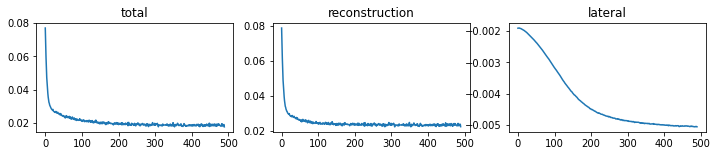

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(12,2))

for i, key in enumerate(losses.keys()):
    axs[i].plot(losses[key][10:])
    axs[i].set_title(key)

Move model to CPU

In [6]:
# Model to CPU
model.cpu()
model.device = 'cpu'
model.psi = model.psi.cpu()

# Data to CPU
data = data.cpu()

Generate reconstructions and latent activity for the data

In [7]:
# Switch to non-differentiable spike counts samples (gives discrete spikes)
model.round_counts(True)

# Run inference
with torch.no_grad():
    xhat, z, pi, p, x = model.forward(data)

Plot reconstruction quality and activity for random samples

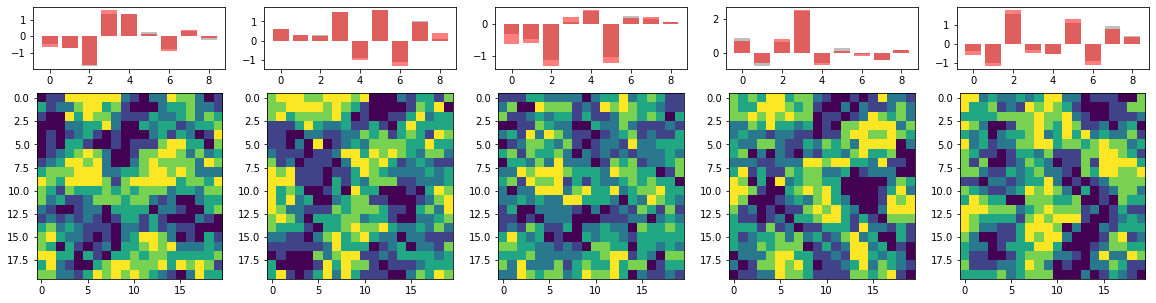

In [8]:
fig, axs = plt.subplots(2,5, figsize=(20,5), gridspec_kw={'height_ratios':[1,3]})

idxs = np.random.choice(10000, 5, replace=False)

for i, idx in enumerate(idxs):
    axs[0,i].bar(range(9), data[idx,:], color='gray', alpha=0.5)
    axs[0,i].bar(range(9), xhat[idx,:], color='red', alpha=0.5)

for i, idx in enumerate(idxs):
    axs[1,i].imshow(z[idx,:].reshape(*LATENT_SHAPE))

### Training & evaluating neuron tuning in a model trained on kinematic data

Load natural and planar reaching kinematic data

In [9]:
# Hyperparameters
BATCH_SIZE = 400

# Load data
natural_data, planar_data = load_kinematic_data('data/kinematic/')

# Move to GPU (remove this line if not using GPU for training)
data = natural_data.cuda()

# Wrap data in dataloader object
dataloader = DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)

Initialise model

In [10]:
# Hyperparameters
LATENT_SHAPE = [80,80] # Dimensions of 2D latent space 
LATENT_DIM = LATENT_SHAPE[0] * LATENT_SHAPE[1] # No. of neurons in 2D latent space
SIGMA = 2 # Controls range of lateral effects
N = 1 # Maximum allowed spike range of each neuron for a single input

# Initialise Psi, which defines the desired pairwise interactions between neurons
psi = lateral_effect(LATENT_SHAPE, SIGMA, mexican_hat)
psi = torch.tensor(psi).float()

# Initialise model
model = BernoulliTopoVAE(data.shape[1], LATENT_DIM, psi, n=N, device='cpu')

# Move model compoinents to GPU (remove these lines if not using GPU for training)
model.device = 'cuda:0'
model.psi = model.psi.cuda()
model.cuda()

BernoulliTopoVAE(
  (encoder): Sequential(
    (0): Linear(in_features=9, out_features=500, bias=False)
    (1): Tanh()
    (2): Linear(in_features=500, out_features=6400, bias=False)
    (3): Sigmoid()
  )
  (decoder): Linear(in_features=6400, out_features=9, bias=False)
)

Train model

In [11]:
# Training hyperparameters
N_EPOCHS = 100
LATERAL_WEIGHT = 20
KL_WEIGHT = 0

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

losses = {'total':[], 'reconstruction':[], 'lateral':[]}

for epoch in range(N_EPOCHS):

    total_losses, recon_losses, lateral_losses = [], [], []

    for i_batch, x in enumerate(dataloader):

        optimizer.zero_grad()

        xhat, z, pi, p, inp = model.forward(x)

        reconstruction_loss = loss_fn(x.cpu(), xhat.cpu())
        lateral_loss = model.lateral_loss(p)
        KL_loss = model.KL_divergence(pi)

        loss = reconstruction_loss + LATERAL_WEIGHT * lateral_loss + KL_WEIGHT * KL_loss
        loss.backward()

        optimizer.step()

        total_losses.append(loss.detach().item())
        recon_losses.append(reconstruction_loss.detach().item())
        lateral_losses.append(lateral_loss.detach().item())
    
    losses['total'].append(np.mean(total_losses))
    losses['reconstruction'].append(np.mean(recon_losses))
    losses['lateral'].append(np.mean(lateral_losses))

    if (epoch+1) % 25 == 0:
        print(f'Epoch {epoch+1}/{N_EPOCHS} | Loss : {np.mean(total_losses)}')



Epoch 25/100 | Loss : 0.024663690477609634
Epoch 50/100 | Loss : 0.023961703509612138
Epoch 75/100 | Loss : 0.022718328159562377
Epoch 100/100 | Loss : 0.017981044081754462


Plot loss curves

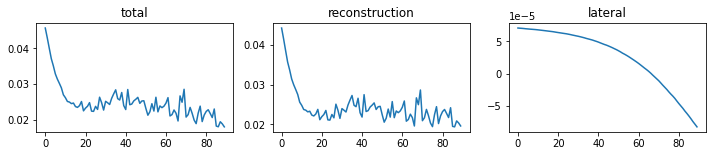

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12,2))

for i, key in enumerate(losses.keys()):
    axs[i].plot(losses[key][10:])
    axs[i].set_title(key)

Move model to CPU

In [13]:
# Model to CPU
model.cpu()
model.device = 'cpu'
model.psi = model.psi.cpu()

# Data to CPU
data = data.cpu()

Generate latent activity for planar reaching

In [14]:
# Switch to non-differentiable spike counts samples (gives discrete spikes)
model.round_counts(True)

# Make dataloader object for planar reaching data
dataloader = DataLoader(planar_data, 1000)

# Run inference on planar kinematic data
with torch.no_grad():
    latent_activity = torch.vstack(
        [model.forward(batch)[1].squeeze().cpu() for batch in dataloader]
    )


Calculate and plot preferred directions of neurons in the latent space

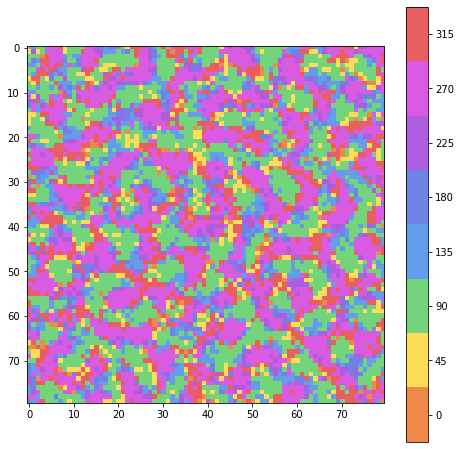

In [15]:
# PD calculation function
get_PD = (
    lambda beta: (np.arctan2(beta[1], beta[0]) % (2 * np.pi)) * 180 / np.pi
) 

# Adjust angle bounds to [0,360]
correct_angle = lambda angle: angle if angle > 0 else 360 + angle

# Load and filter endpoint data from planar reaching data
with h5py.File("data/kinematic/planar/planar_data.h5", "r") as file:
    endpoint_data = file["endvelocity"][:]
    centre_out_idxs = np.hstack(
        [range(1000, 11000), range(16000, 21000), range(26000, 27000)]
    )
    endpoint_data = endpoint_data[centre_out_idxs, :]

# Train Poisson GLM mapping endpoint data to latent activity
model_glm = MultiOutputRegressor(
    PoissonRegressor(fit_intercept=False), n_jobs=-1
).fit(endpoint_data, latent_activity)

# Calculate preferred directions for each neuron in the model
PDs = [get_PD(model_glm.estimators_[i].coef_) for i in range(latent_activity.shape[1])] 

# Plot map of preferred directions across the latent space 
plot_PD_map(PDs)